# Flood Atmospheric Event Analysis
Read in NCEP-NCAR Reanalysis 3 data, form average anomalies three months prior to flood, plot and write output to .csv file so it can be plotted in ArcMap

To run: download the following files from https://psl.noaa.gov/data/gridded/data.20thC_ReanV3.html
- air 
- hgt
- prate
- pres
- runoff 
- snod
- soilw 
- uwnd 
- vwnd 

Place all files in one folder and change link in next block

In [ ]:
#local data paths 
riv_path = r'D:\Data\river data\USGS\top_ten.csv' #this file is in the "data" folder on Github repo
data_dir = r'D:\Data\NCEP NCAR Reanalysis 3\Monthly Means' #change to folder on local machine 
write_location= r'C:\Users\bydd1\Downloads'

In [2]:
#import packages
import pandas as pd
import vis_methods as vm 
import env_methods as em
from netCDF4 import Dataset
import os 
import time as pytime
from copy import deepcopy
import matplotlib.pyplot as plt 
import cartopy 
import cartopy.crs as ccrs
import numpy as np 

## Get flood dates
Read Excel file containing the top 10 flood dates for locations on the Mississippi  
The two points of interest (Hermann, MO and Louisville, KY) are plotted on the backdrop of the Mississippi river system. 

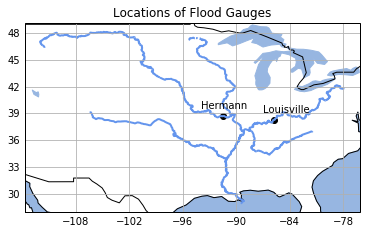

In [3]:
riv_dates = pd.read_csv(riv_path)
riv_dates = riv_dates.drop(columns = 'vicksburg')
vm.plot_poi()

## netCDF data extraction

Get relevant metadata for chosen variables - here we look at air temperature at the 2m level, snow coverage, volumetric soil moisture, and water runoff

In [4]:
os.chdir(data_dir)
files = os.listdir()
files = [f for f in files if f[-5:6] != 'ltm.nc']

not_var = ['lat', 'lon', 'time', 'time_bnds', 'level', 'climatology_bounds', 'valid_yr_count']
var_df = pd.DataFrame(index = ['description', 'location', 'units', 'level', 'missing_val'])
for f in files: 
    x = Dataset(f)
    print(x.title)
    keys = list(x.variables)
    level_bool = False
    if 'level' in keys: level_bool = True
    
    varname = [k for k in keys if k not in not_var][0]
    desc = x[varname].var_desc
    na = x[varname].missing_value
    var_df[varname] = [desc, os.path.join(data_dir, f), x[varname].units, level_bool, na]
not_var = not_var[:-2]  
var_df


Monthly NOAA/CIRES/DOE 20th Century Reanalysis V3
Monthly NOAA/CIRES/DOE 20th Century Reanalysis V3
Monthly NOAA/CIRES/DOE 20th Century Reanalysis V3
Monthly NOAA/CIRES/DOE 20th Century Reanalysis V3
Monthly NOAA/CIRES/DOE 20th Century Reanalysis V3
Monthly NOAA/CIRES/DOE 20th Century Reanalysis V3
Monthly NOAA/CIRES/DOE 20th Century Reanalysis V3
Monthly NOAA/CIRES/DOE 20th Century Reanalysis V3
Monthly NOAA/CIRES/DOE 20th Century Reanalysis V3
Monthly NOAA/CIRES/DOE 20th Century Reanalysis V3
Monthly NOAA/CIRES/DOE 20th Century Reanalysis V3
Monthly NOAA/CIRES/DOE 20th Century Reanalysis V3


,air,hgt,prate,pres,runoff,snod,soilw,uwnd,vwnd
description,Air temperature,Geopotential height,Precipitation Rate,Pressure,Water Runoff,snow depth,Volumetric Soil Moisture,u-wind,v-wind
location,D:\Data\NCEP NCAR Reanalysis 3\Monthly Means\a...,D:\Data\NCEP NCAR Reanalysis 3\Monthly Means\h...,D:\Data\NCEP NCAR Reanalysis 3\Monthly Means\p...,D:\Data\NCEP NCAR Reanalysis 3\Monthly Means\p...,D:\Data\NCEP NCAR Reanalysis 3\Monthly Means\r...,D:\Data\NCEP NCAR Reanalysis 3\Monthly Means\s...,D:\Data\NCEP NCAR Reanalysis 3\Monthly Means\s...,D:\Data\NCEP NCAR Reanalysis 3\Monthly Means\u...,D:\Data\NCEP NCAR Reanalysis 3\Monthly Means\v...
units,degK,m,kg/m^2/s,Pa,kg/m^2,m,frac.,m/s,m/s
level,False,True,False,False,False,False,True,True,True
missing_val,-9.96921e+36,-9.96921e+36,-9.96921e+36,-9.96921e+36,-9.96921e+36,-9.96921e+36,-9.96921e+36,-9.96921e+36,-9.96921e+36


Get parameter values - lat, lon, and level, if it exists 

In [5]:
#are there any variables with 'level' data? What rows?
if True in list(var_df.loc['level']):
    index = list(var_df.loc['level']).index(True)
varname = var_df.iloc[:, index].name #find variable name that has a True for 'level'
x = Dataset(var_df[varname]['location'])

par_df = {}
for v in not_var:
    par_df[v] = x[v][:].data
    

In [6]:
import datetime as dt 
origin_string = x['time'].units
time = [em.convert_datetime(t, origin_string) for t in par_df['time']]
par_df['time'] = time

In [7]:
riv_time_ind = pd.DataFrame()
for loc in riv_dates.columns.tolist():
    riv_dates[loc] = pd.to_datetime(riv_dates[loc], format = "%m/%d/%Y") #convert to dt object
    loc_ind = []
    
    for event in riv_dates[loc]:
        ind = em.find_closest_val(event, par_df['time'])
        loc_ind.append(ind)
        
    riv_time_ind[loc] = loc_ind
    
riv_time_ind

,hermann,louisville
0,1891,1213
1,809,1310
2,1387,578
3,1913,1538
4,1300,927
5,1289,566
6,1809,1934
7,2159,853
8,1648,2150
9,1338,1167


In [8]:
bbox = {'lat' : [0, 60],
        'lon' : [-170, -10]}

for i in range(len(bbox['lon'])):
    val = bbox['lon'][i]
    if val < 0:
        bbox['lon'][i] = 180 - val
if bbox['lon'][0] > bbox['lon'][1]: bbox['lon'] =  [bbox['lon'][1], bbox['lon'][0]]

bbox_c = {'lat': [em.find_closest_val(i, par_df['lat']) for i in bbox['lat']],
         'lon': [em.find_closest_val(i, par_df['lon']) for i in bbox['lon']]}

bbox_c
par_df['lat'] = par_df['lat'][bbox_c['lat'][0]:bbox_c['lat'][1]]
par_df['lon'] = par_df['lon'][bbox_c['lon'][0]:bbox_c['lon'][1]]

#### Get all data

#### Formatting data

In [9]:
start_time = pytime.time()
data = {}
mv = var_df['air']['missing_val']

for var in var_df:
    x = Dataset(var_df[var]['location'])
    if var_df[var]['level']:
        if var == 'soilw':
            level = x['level'][:].data.tolist()
            for l in level:
                l_i = level.index(l)
                d =  np.asarray(x[var][:, l_i, bbox_c['lat'][0]:bbox_c['lat'][1], bbox_c['lon'][0]:bbox_c['lon'][1] ])
                d[d == mv] = np.nan
                data['soilw' + '_' + str(l)] = d
        if var in ['hgt', 'uwnd', 'vwnd']:
            level = x['level'][:].data.tolist()
            x_850 = level.index(850)
            x_1000 = level.index(1000)
            d =  np.asarray(x[var][:, x_850, bbox_c['lat'][0]:bbox_c['lat'][1], bbox_c['lon'][0]:bbox_c['lon'][1] ])
            d[d == mv] = np.nan
            data[var + '_' + '850mb'] = d
            
            d = np.asarray(x[var][:, x_1000, bbox_c['lat'][0]:bbox_c['lat'][1], bbox_c['lon'][0]:bbox_c['lon'][1]])
            data[var + '_' + '1000mb'] = d
    else: 
        d = np.asarray(x[var][:, bbox_c['lat'][0]:bbox_c['lat'][1], bbox_c['lon'][0]:bbox_c['lon'][1] ])
        d[d == mv] = np.nan
        data[var] = d
print(pytime.time() - start_time )

234.3026568889618


In [10]:
start_time = pytime.time()
anom_data = {}
for var in data: 
    d = deepcopy(data[var])
    d[np.isnan(d)] = 0
    d = em.normalize_data(d, time)
    d[d == 0] = np.nan
    d[d == 0.0] = np.nan
    anom_data[var] = d
    
print(pytime.time() - start_time)

C:\Users\bydd1\OneDrive\Documents\Research\Code for Babes\miss-atmo\env_methods.py:134: RuntimeWarning: invalid value encountered in true_divide
  stdev_monthly[month - 1])


47.38999032974243


In [11]:
data.keys()
anom_data.keys()

dict_keys(['air', 'hgt_850mb', 'hgt_1000mb', 'prate', 'pres', 'runoff', 'snod', 'soilw_0.0', 'soilw_10.0', 'soilw_40.0', 'soilw_100.0', 'uwnd_850mb', 'uwnd_1000mb', 'vwnd_850mb', 'vwnd_1000mb'])

In [12]:
os.chdir(write_location)
c = ['lat', 'lon']
for v in data:
    c.append('stand_' + v)
    c.append(v)
    
for loc in riv_time_ind: 
    frame = {}
    for n in c: 
        frame[n] = []
    
    data_temp = deepcopy(data)
    anom_data_temp = deepcopy(anom_data)
    for d in [data_temp, anom_data_temp]:
        for v in data: 
            d[v] = np.nanmean(d[v][riv_time_ind[loc], :, :], axis = 0)

    counter = 0 
    for i in range(len(par_df['lat'])):
        for j in range(len(par_df['lon'])):
            frame['lat'].append(par_df['lat'][i])
            frame['lon'].append(par_df['lon'][j])
            for v in data:
                frame['stand_' + v].append(anom_data_temp[v][i, j])
                frame[v].append(data_temp[v][i, j])
    frame = pd.DataFrame(frame)   
    frame.fillna(-9999)
    frame.to_csv(loc + '.csv')

C:\Users\bydd1\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


In [13]:
### testing! 

hermann = pd.read_csv('hermann.csv')
louisville = pd.read_csv('louisville.csv')


for f in ['h', 'l']:
    dic ={}
    if f == 'h':
        file = hermann
    if f == 'l':
        file = louisville
    for v in file: 
        if v not in ['Unnamed: 0', 'lat', 'lon']:
            array = np.zeros((len(par_df['lat']), len(par_df['lon'])))
            lat = par_df['lat'].tolist()
            lon = par_df['lon'].tolist()
            for k in range(len(file)):


                lat_ = file['lat'][k]
                lon_ = file['lon'][k]

                lat_i = lat.index(lat_)
                lon_i = lon.index(lon_)

                array[lat_i, lon_i] = file[v][k]
                array[array == -9999] = np.nan
            dic[v] = array
            
    if f == 'h': hermann_dic = deepcopy(dic)
    if f == 'l': louisville_dic = deepcopy(dic)


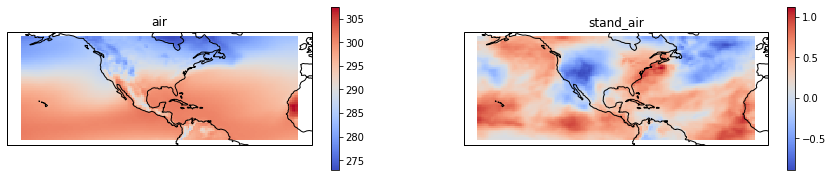

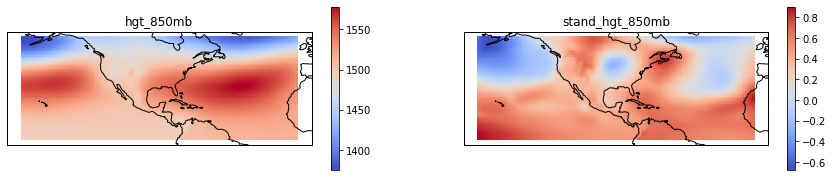

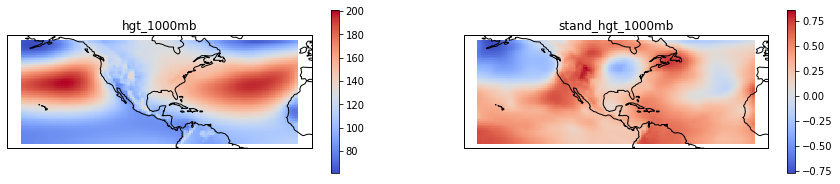

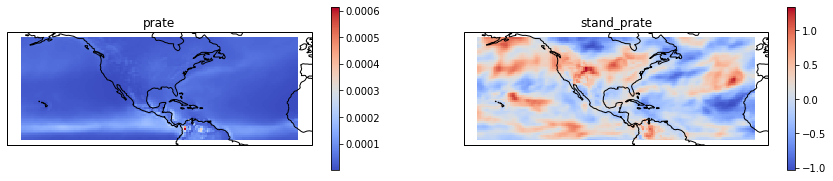

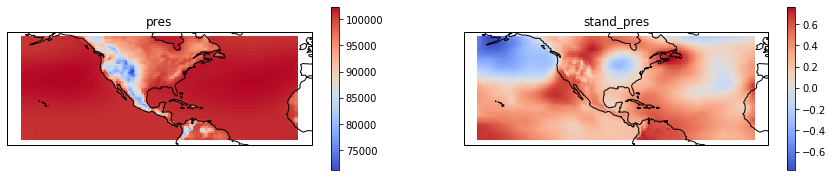

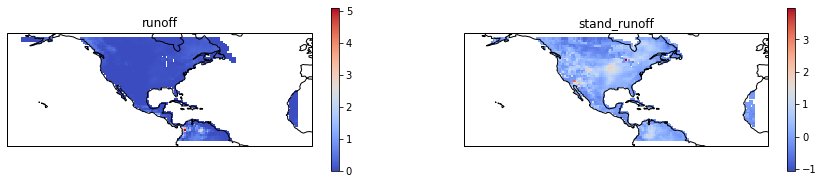

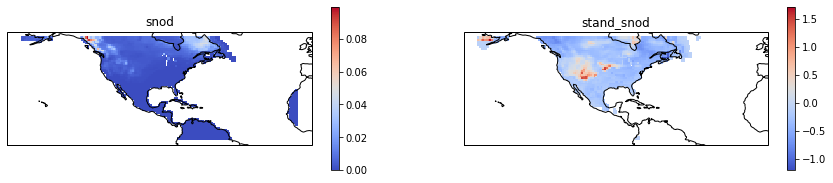

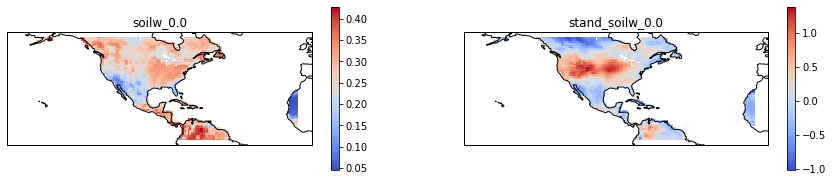

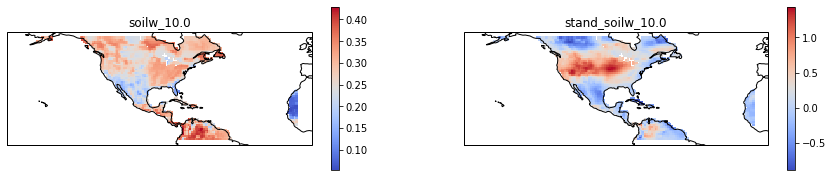

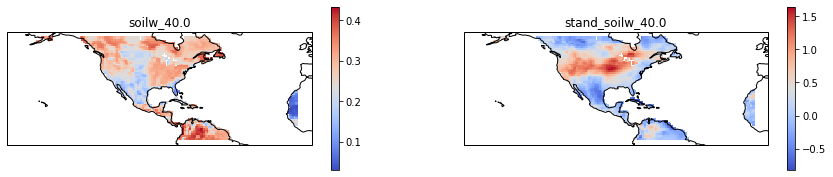

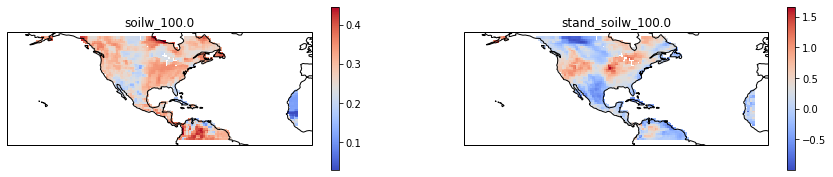

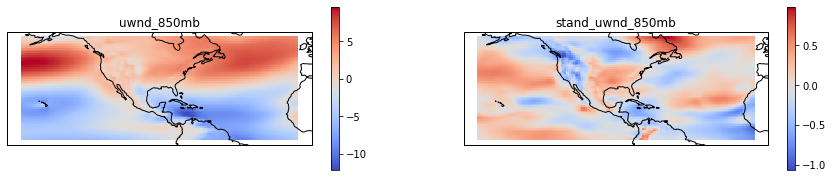

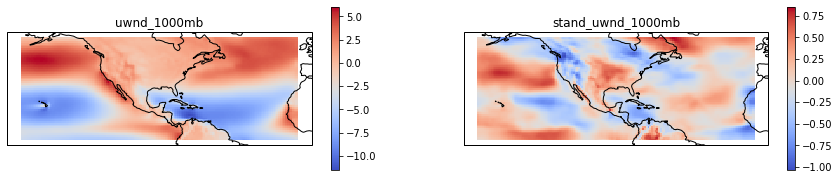

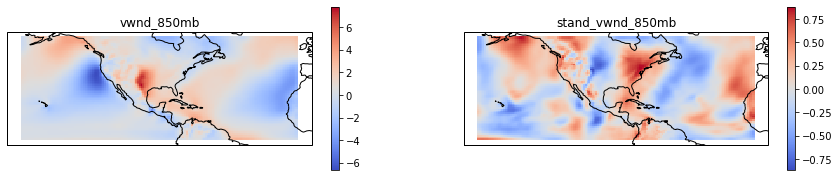

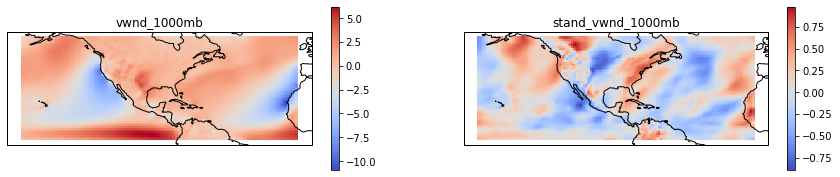

In [14]:
d = hermann_dic
for v in d:
    if v[:5] != 'stand':
        plt.figure(figsize = (15, 3))
        ax = plt.subplot(1, 2, 1, projection = ccrs.PlateCarree())
        ax.coastlines()
        mesh = plt.pcolormesh(lon, lat, d[v], cmap = 'coolwarm')
        plt.title(v)
        plt.colorbar(mesh)
        ax = plt.subplot(1, 2, 2, projection = ccrs.PlateCarree())
        ax.coastlines()
        mesh = plt.pcolormesh(lon, lat, d['stand_' + v], cmap = 'coolwarm')
        plt.title('stand_' + v)
        plt.colorbar(mesh)

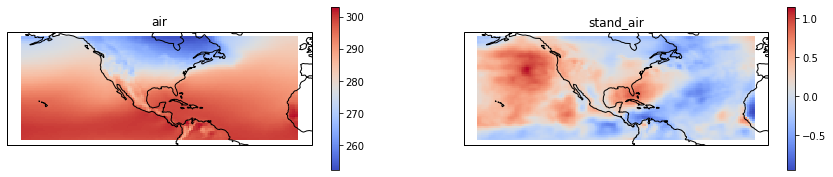

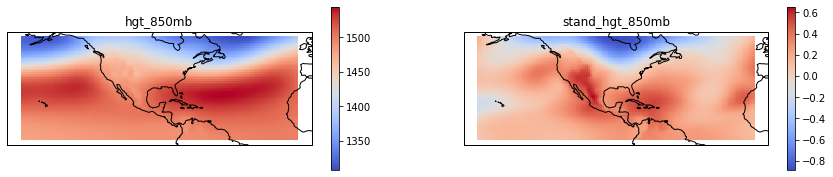

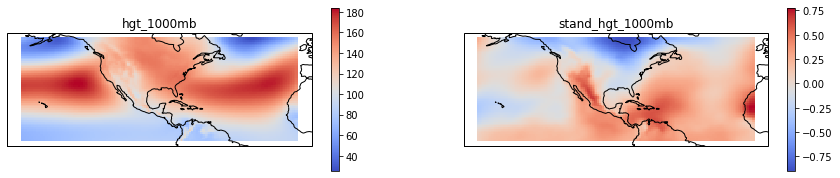

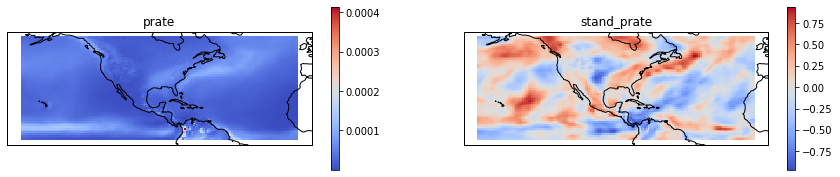

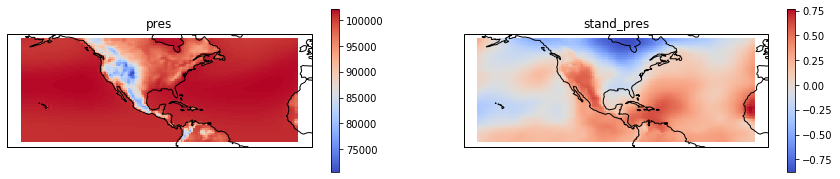

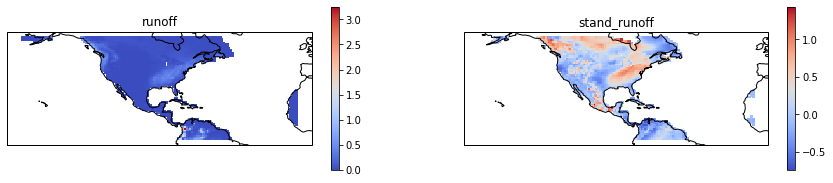

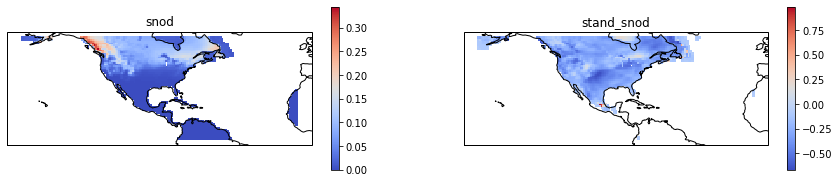

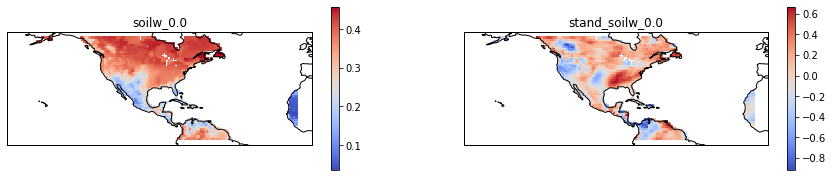

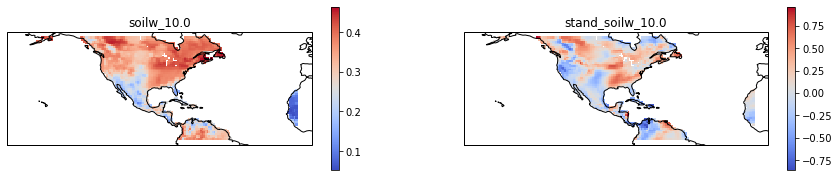

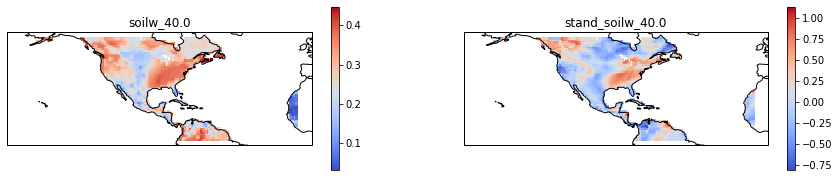

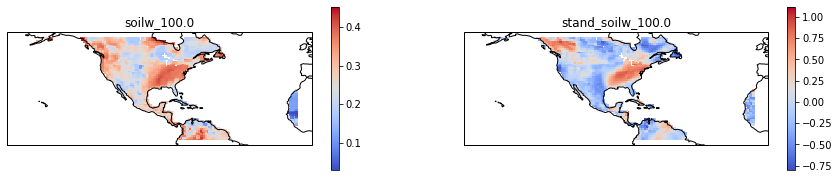

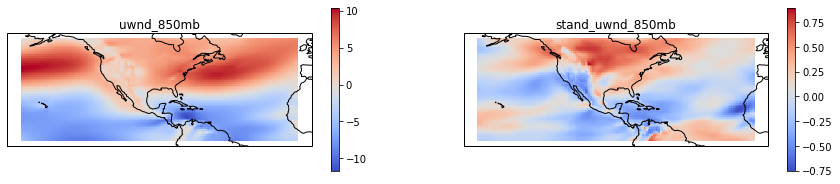

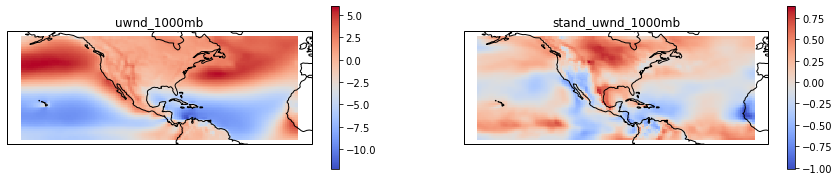

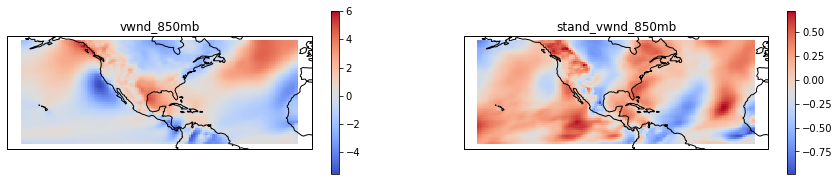

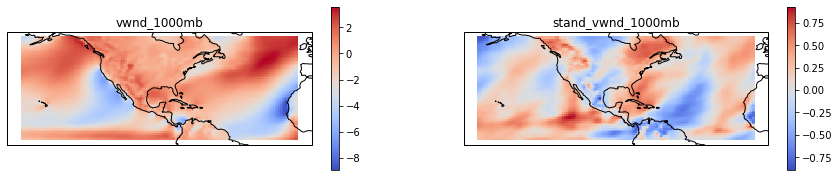

In [15]:
d = louisville_dic
for v in d:
    if v[:5] != 'stand':
        plt.figure(figsize = (15, 3))
        ax = plt.subplot(1, 2, 1, projection = ccrs.PlateCarree())
        ax.coastlines()
        mesh = plt.pcolormesh(lon, lat, d[v], cmap = 'coolwarm')
        plt.title(v)
        plt.colorbar(mesh)
        ax = plt.subplot(1, 2, 2, projection = ccrs.PlateCarree())
        ax.coastlines()
        mesh = plt.pcolormesh(lon, lat, d['stand_' + v], cmap = 'coolwarm')
        plt.title('stand_' + v)
        plt.colorbar(mesh)

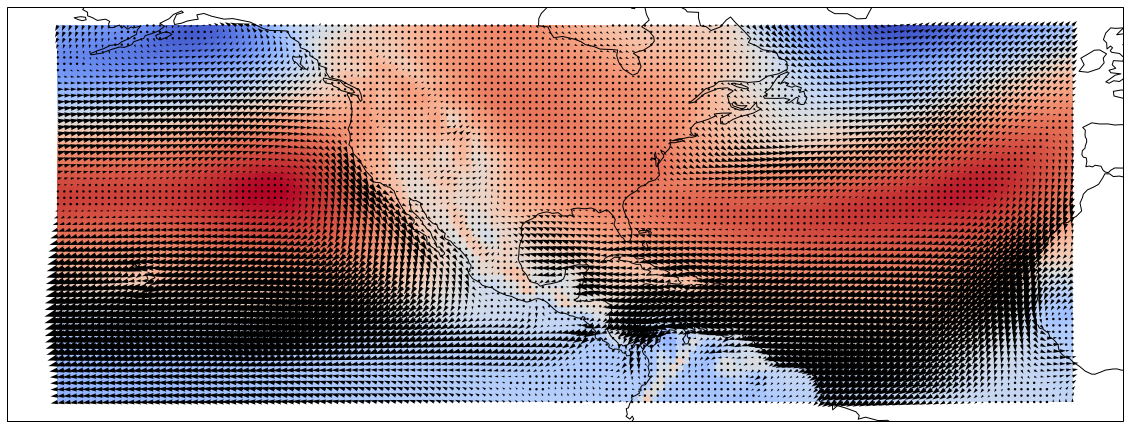

In [16]:
plt.figure(figsize = (20, 20))
ax = plt.subplot(projection = ccrs.PlateCarree())
ax.coastlines()
plt.pcolormesh(lon, lat, d['hgt_1000mb'], cmap = 'coolwarm')
plt.quiver(lon, lat, d['uwnd_1000mb'], d['vwnd_1000mb'])
